In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
from progressbar import progressbar
import scipy.stats
import statsmodels.stats.power as power
import statsmodels.formula.api as sfa
from functools import partial
import matplotlib.pyplot as plt
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})


# Exercises

This notebook builds on the notes in: [lecture-05-inference_complications.ipynb](https://colab.research.google.com/drive/15HffRKGBXlk_0u-IXvyza06y3Mt7_NTI).

This notebook is **all** of problem set 5. The "In-class foundations" will count as 50 percent.

## Part 1

We will further explore the bias in: 'In the section "Adjusting randomization proportions during experiment'.


#### Weaknesses of the Bonferroni correction (40 points)

We will return to the section "Simulation to analyze power of procedures". Our goal is to understand how dependence in the hypothesis tests reduces power when we use the Bonferroni correction.

We need to create dependent hypothesis tests in our function `run_one_study`. You can replace your 80 independent normal random variables with 80 correlated random variables like this: `np.ones` creates an array entirely full of ones. We multiply it by a covariance between 0 and 1. `np.eye` creates a diagonal matrix with 1s on the diagonal and zeros elsewhere. We multiply by (1-covariance) to make the matrix `cov` always have 1s on the diagonal (i.e., all our variables will have variance=1). Substitute these into the data-generating process. Add a parameter `covariance` to your function so you can easily adjust the amount of covariance in your tests.

If this isn't clear look at the `numpy` documentation.

```
cov = covariance*np.ones((number_of_hypotheses, number_of_hypotheses)) + (1-covariance)*np.eye(number_of_hypotheses)

dataset = np.random.multivariate_normal(mean=effects, cov=cov, size=N_sample_size)
```

1. What does it mean for the hypothesis tests to be dependent? Why does this code make the hypothesis tests dependent?

2. We are going to repeat "Simulation to analyze power of procedures" with different values for covariance. We are just looking at the Bonferroni correction right now. The notebook already gives you the results for covariance=0 (why?). We will also try very high covariance, 0.95. Simulate the high covariance DGP, and re-run the power and FWER calculations that are already in the notebook. Carefully compare these between covariance=0 and covariance=0.95. What do we mean when we say the Bonferroni correction is **very conservative** when there is dependence in the hypothesis tests?

3. Try adjusting the  𝛼  parameter of your Bonferroni test. What power can you achieve while still controlling FWER < 0.05?

4. In the Bonferroni correction power result in the notebook we calculated the power for the first 5 hypotheses using the simulated data and a special function from `statsmodels`. Reproduce these by manually coding it in your notebook. This should just be 1 or 2 lines of code. Show your code in the answer.

#### Homework for Bonferroni correction (30 points)

5. Repeat (2) but analyze the performance of the BH correction under high and low covariance. Is the BH as sensitive to covariance?

6. Intuitively, why is the Bonferroni correction conservative when there is dependence?

7. Describe an example experiment where hypothesis tests might be dependent?

8. (Bonus +5) In the covariance matrix, why do we need to make sure the diagonal is always 1s, even when we change the covariance?

9. (Bonus +5) In problem 6, sketch the proof using a mathematical (theory) argument.


#### Peeking factors (20 points)

10. Let's repeat the section 'Simulating the "peeking" experiments'. However we will peek less frequently. We started with $N=200$, but let's suppose we only peek once per day. We are a small website so we get just 50 visitors per day. You just need to modify `n_index = np.arange(4, df.shape[0])`. See the `np.arange` documentation on how to get only every k-th number in the range. How does decreasing the peeking frequency affect your false positive rate?

11. Is "peeking" at the results literally a problem? That is, does just looking at your statistical results make them invalid? Explain.



#### Homework for peeking (10 points)

12. Repeat the simulation in the lecture notes notebook: 'Simulating the "peeking" experiments' but with $N=5000$. This takes longer so decrease to $B=500$. What is your overall false positive rate now? Try $N=10,000$ and $B=200$. What do you think happens to your false positive rate if you are willing to keep running each experiment forever?

13. In a real-life situation, what are some reasons that you **should** peek at your experiment results?












#Part 1
##1

This test became dependent as we put covariances in matrix, though before our correlations between metrics were equal to 0. So now they have dependence.

##2

The notebook already gives you the results for covariance=0 as we normally distributed them. In other words, the scale is always = 1 and other elements of matrix = 0.

In [ ]:
def run_one_study(effect, covariance, false_nulls=[]):
  N_sample_size = 100
  number_of_hypotheses = 80

  # If we want to plug in an actual effect for some of
  # the measurements, we can pass a list of column numbers
  # where we want to have `effect` rather than 0.
  effects = np.zeros(number_of_hypotheses)
  if false_nulls != []:
    effects[false_nulls] = effect

  cov = covariance*np.ones((number_of_hypotheses, number_of_hypotheses)) + (1-covariance)*np.eye(number_of_hypotheses)
  # Make an array with N_sample_size rows and number_of_hypotheses columns.
  # Each value is a draw from Normal(0, 1). We interpret this is as
  # 100 units, each having 8 measurements.  We want to test whether
  # the measurements are on average different from zero.
  dataset = np.random.multivariate_normal(mean=effects, cov=cov, size=N_sample_size)

  # This function does a 1-sample t-test on each column of the data.
  # We are testing the hypothesis that the expectation of the column
  # is 0.
  test_results = stats.ttest_1samp(dataset, 0)
  pvalues = pd.Series(test_results.pvalue)
  return pvalues

In [ ]:
from scipy import stats
B = 5000
np.random.seed(94115)
# Set the first 5 hypotheses to have an effect (loc!=0).
# The remainder have no effect (loc=0).
indices_has_effect = [0,1,2,3,4]
pvalues_many_studies = [run_one_study(0.3, 0.95, indices_has_effect) for _ in progressbar(np.arange(B))]
pvalues_uncorrected = pd.DataFrame(pvalues_many_studies)
rejections_uncorrected = (pvalues_uncorrected < 0.05).cummax(axis=1)

100% (5000 of 5000) |####################| Elapsed Time: 0:00:17 Time:  0:00:17


In [ ]:
def fdr(reject_corrected, indices_has_effect=indices_has_effect):
  # Assumes that the first few indices can have true effects
  # but the remaining columns will have true null hypotheses.
  discoveries = reject_corrected.sum(axis=1)
  false_discoveries = reject_corrected.loc[:, (indices_has_effect[-1] + 1):].sum(axis=1)
  # False discovery quotient is defined as 0 when there are no rejections.
  return (false_discoveries / discoveries).fillna(0).mean()

def fwer(reject_corrected, indices_has_effect=indices_has_effect):
  # Assumes that the first few indices can have true effects
  # but the remaining columns will have true null hypotheses.
  any_false_discoveries = reject_corrected.loc[:, (indices_has_effect[-1] + 1):].max(axis=1)
  # False discovery quotient is defined as 0 when there are no rejections.
  return any_false_discoveries.mean()



In [ ]:
from statsmodels.sandbox.stats.multicomp import multipletests
def get_multi_tester(result_type):
  def multi_test_results(pvalues_row):
    reject, pvals_corrected, _, _ = multipletests(pvalues_row, alpha=0.05, method=result_type)
    return reject
  return multi_test_results

In [ ]:
multi_test_results = get_multi_tester('bonferroni') 
reject_corrected = pvalues_uncorrected.apply(multi_test_results, axis=1, result_type='expand')

# Power using bonferroni correction
print("Power for the first 5 tests (Bonferroni):")
print(reject_corrected.loc[:, indices_has_effect].mean(axis=0))


print("\nFWER (Bonferroni) = ", fwer(reject_corrected))
print("\nFDR (Bonferroni) = ", fdr(reject_corrected))

Power for the first 5 tests (Bonferroni):
0    0.3026
1    0.3050
2    0.3044
3    0.3058
4    0.3006
dtype: float64

FWER (Bonferroni) =  0.0028

FDR (Bonferroni) =  0.0026481451148390816


In [ ]:
B = 5000
np.random.seed(94115)
# Set the first 5 hypotheses to have an effect (loc!=0).
# The remainder have no effect (loc=0).
indices_has_effect = [0,1,2,3,4]
pvalues_many_studies = [run_one_study(0.3, 0, indices_has_effect) for _ in progressbar(np.arange(B))]
pvalues_uncorrected = pd.DataFrame(pvalues_many_studies)
rejections_uncorrected = (pvalues_uncorrected < 0.05).cummax(axis=1)

100% (5000 of 5000) |####################| Elapsed Time: 0:00:13 Time:  0:00:13


In [ ]:
multi_test_results = get_multi_tester('bonferroni') 
reject_corrected = pvalues_uncorrected.apply(multi_test_results, axis=1, result_type='expand')

# Power using bonferroni correction
print("Power for the first 5 tests (Bonferroni):")
print(reject_corrected.loc[:, indices_has_effect].mean(axis=0))


print("\nFWER (Bonferroni) = ", fwer(reject_corrected))
print("\nFDR (Bonferroni) = ", fdr(reject_corrected))

Power for the first 5 tests (Bonferroni):
0    0.3064
1    0.2966
2    0.3174
3    0.3064
4    0.3012
dtype: float64

FWER (Bonferroni) =  0.049

FDR (Bonferroni) =  0.023536666666666647


the Bonferroni correction is very conservative when there is dependence in the hypothesis tests as it is so close to 0, as we have covariance = 0.95 but error is closer to 0, as compared to alpha. 

##3

In [ ]:
from statsmodels.sandbox.stats.multicomp import multipletests
def get_multi_tester(alpha, result_type):
  def multi_test_results(pvalues_row):
    reject, pvals_corrected, _, _ = multipletests(pvalues_row, alpha=alpha, method=result_type)
    return reject
  return multi_test_results

In [ ]:
alpha = 0.05

In [ ]:
#B = 5000
#np.random.seed(94115)
# Set the first 5 hypotheses to have an effect (loc!=0).
# The remainder have no effect (loc=0).
#indices_has_effect = [0,1,2,3,4]
#pvalues_many_studies = [run_one_study(0.3, indices_has_effect) for _ in progressbar(np.arange(B))]
#pvalues_uncorrected = pd.DataFrame(pvalues_many_studies)
#rejections_uncorrected = (pvalues_uncorrected < 0.05).cummax(axis=1)

In [ ]:
B = 5000
np.random.seed(94115)
# Set the first 5 hypotheses to have an effect (loc!=0).
# The remainder have no effect (loc=0).
indices_has_effect = [0,1,2,3,4]
pvalues_many_studies = [run_one_study(0.3, 0.95, indices_has_effect) for _ in progressbar(np.arange(B))]
pvalues_uncorrected = pd.DataFrame(pvalues_many_studies)
rejections_uncorrected = (pvalues_uncorrected < 0.05).cummax(axis=1)

100% (5000 of 5000) |####################| Elapsed Time: 0:00:17 Time:  0:00:17


In [ ]:
# Do a manual Bonferroni correction on the p-values and calculate the FWER
alpha = [0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.30, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8]
fwer_bonferroni = []
for i in np.arange(0, 14):
  fwer = (pvalues_uncorrected.iloc[:, 5:] < (alpha[i] / 80)).max(axis=1).mean()
  fwer_bonferroni.append({'fwer': fwer, 'alpha': alpha[i]})
  
fwer_bonferroni = pd.DataFrame(fwer_bonferroni)

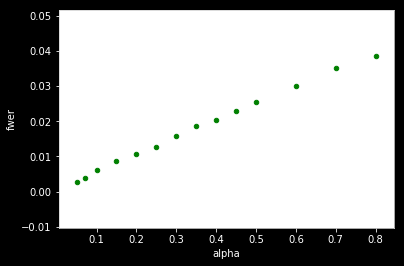

In [ ]:
fwer_bonferroni.plot(kind = 'scatter', x = 'alpha', y = 'fwer', color = 'green')

In [ ]:
reject_uncorrected = (pvalues_uncorrected < 0.05)
print(reject_uncorrected.loc[:, :4].mean(axis=0))

0    0.8456
1    0.8474
2    0.8370
3    0.8400
4    0.8424
dtype: float64


####Second question of q. 3

In [ ]:
def get_multi_tester(result_type):
  def multi_test_results(pvalues_row):
    reject, pvals_corrected, _, _ = multipletests(pvalues_row, alpha=0.01, method=result_type)
    return reject
  return multi_test_results

In [ ]:
multi_test_results = get_multi_tester('bonferroni') 
reject_corrected = pvalues_uncorrected.apply(multi_test_results, axis=1, result_type='expand')

# Power using bonferroni correction
print("Power for the first 5 tests (Bonferroni):")
print(reject_corrected.loc[:,:4].mean(axis=0))

Power for the first 5 tests (Bonferroni):
0    0.1732
1    0.1722
2    0.1690
3    0.1716
4    0.1726
dtype: float64


In [ ]:
def get_multi_tester(result_type):
  def multi_test_results(pvalues_row):
    reject, pvals_corrected, _, _ = multipletests(pvalues_row, alpha=0.8, method=result_type)
    return reject
  return multi_test_results

In [ ]:
multi_test_results = get_multi_tester('bonferroni') 
reject_corrected = pvalues_uncorrected.apply(multi_test_results, axis=1, result_type='expand')

# Power using bonferroni correction
print("Power for the first 5 tests (Bonferroni):")
print(reject_corrected.loc[:,:4].mean(axis=0))

Power for the first 5 tests (Bonferroni):
0    0.6458
1    0.6436
2    0.6450
3    0.6428
4    0.6458
dtype: float64


##4

In the Bonferroni correction power result in the notebook we calculated the power for the first 5 hypotheses using the simulated data and a special function from statsmodels. Reproduce these by manually coding it in your notebook. This should just be 1 or 2 lines of code. Show your code in the answer.

In [ ]:
np.random.seed(94115)
B = 5000
indices_has_effect = [0,1,2,3,4]
# Simulate 5000 studies, each with N=100 and 80 hypotheses.
# We set all nulls to be true.
pvalues_many_studies = [run_one_study(0.3, 0.95, indices_has_effect) for _ in progressbar(np.arange(B))]
pvalues_uncorrected = pd.DataFrame(pvalues_many_studies)
rejections_uncorrected = (pvalues_uncorrected < 0.05).cummax(axis=1)

100% (5000 of 5000) |####################| Elapsed Time: 0:00:17 Time:  0:00:17


In [ ]:
reject_uncorrected = (pvalues_uncorrected < 0.05)

# Power using bonferroni correction
print("Power for the first 5 tests (uncorrected):")
print(reject_uncorrected.loc[:, indices_has_effect].mean(axis=0))

Power for the first 5 tests (uncorrected):
0    0.8456
1    0.8474
2    0.8370
3    0.8400
4    0.8424
dtype: float64


In [ ]:
reject_uncorrected1 = (pvalues_uncorrected < 0.05).mean(axis = 0)
reject_uncorrected1

0     0.8456
1     0.8474
2     0.8370
3     0.8400
4     0.8424
5     0.0482
6     0.0470
7     0.0480
8     0.0466
9     0.0496
10    0.0490
11    0.0486
12    0.0508
13    0.0470
14    0.0474
15    0.0486
16    0.0490
17    0.0506
18    0.0464
19    0.0494
20    0.0494
21    0.0478
22    0.0496
23    0.0452
24    0.0470
25    0.0460
26    0.0466
27    0.0460
28    0.0494
29    0.0514
       ...  
50    0.0490
51    0.0482
52    0.0470
53    0.0486
54    0.0470
55    0.0480
56    0.0478
57    0.0480
58    0.0486
59    0.0490
60    0.0486
61    0.0484
62    0.0486
63    0.0492
64    0.0466
65    0.0502
66    0.0496
67    0.0476
68    0.0476
69    0.0462
70    0.0480
71    0.0498
72    0.0466
73    0.0494
74    0.0498
75    0.0506
76    0.0466
77    0.0498
78    0.0476
79    0.0494
Length: 80, dtype: float64

##5 

In [ ]:
B = 5000
np.random.seed(94115)
# Set the first 5 hypotheses to have an effect (loc!=0).
# The remainder have no effect (loc=0).
indices_has_effect = [0,1,2,3,4]
pvalues_many_studies = [run_one_study(0.3, 0.95, indices_has_effect) for _ in progressbar(np.arange(B))]
pvalues_uncorrected = pd.DataFrame(pvalues_many_studies)
rejections_uncorrected = (pvalues_uncorrected < 0.05).cummax(axis=1)

 14% (747 of 5000) |###                  | Elapsed Time: 0:00:02 ETA:   0:00:14

KeyboardInterrupt: ignored

In [ ]:
from statsmodels.sandbox.stats.multicomp import multipletests
def get_multi_tester(result_type):
  def multi_test_results(pvalues_row):
    reject, pvals_corrected, _, _ = multipletests(pvalues_row, alpha=0.05, method=result_type)
    return reject
  return multi_test_results

In [ ]:
multi_test_results = get_multi_tester('fdr_bh') 
reject_corrected = pvalues_uncorrected.apply(multi_test_results, axis=1, result_type='expand')

# Power using BH correction
print("Power for the first 5 tests (BH):")
print(reject_corrected.loc[:, indices_has_effect].mean(axis=0))

#print("\nFWER (BH) = ", fwer(reject_corrected))
print("\nFDR (BH) = ", fdr(reject_corrected))

In [ ]:
B = 5000
np.random.seed(94115)
# Set the first 5 hypotheses to have an effect (loc!=0).
# The remainder have no effect (loc=0).
indices_has_effect = [0,1,2,3,4]
pvalues_many_studies = [run_one_study(0.3, 0, indices_has_effect) for _ in progressbar(np.arange(B))]
pvalues_uncorrected = pd.DataFrame(pvalues_many_studies)
rejections_uncorrected = (pvalues_uncorrected < 0.05).cummax(axis=1)

In [ ]:
multi_test_results = get_multi_tester('fdr_bh') 
reject_corrected = pvalues_uncorrected.apply(multi_test_results, axis=1, result_type='expand')

# Power using BH correction
print("Power for the first 5 tests (BH):")
print(reject_corrected.loc[:, indices_has_effect].mean(axis=0))

#print("\nFWER (BH) = ", fwer(reject_corrected))
print("\nFDR (BH) = ", fdr(reject_corrected))

##6

Answer: the Bonfferoni method is more conservative when the events of rejecting hypothesises are dependent. The reason for it is that their covariance is not zero. In other words, the probability of (we reject the first hypothesis and reject the second hypothesis) is very small. Obtaining both of these events are more difficult than obtainng them if they are independent as it means that we have to reject both of them to reach our goal. When they are independent, we need just to occur one event out of all of them.

##7

Example: the treatment is doing masters degree program. There are different effects. First, people will obtain more knowledge. Second, these students will be more likely to get job in future. This two effects could be considered as hypothesises tests. Hypothesis one: Necessary knowledge = 0. Hypothesis two: No getting job. Clearly, they might me dependent.

##8

Answer: in covariance matrix the main diagonal is variances of same variables. It will be always equal to 1 as if variable X changes to some value the same X will always change with probability 1 to the value as they are the same variables. Its covariance of variable to itself.

##9

P(A or B) = P(A) + P(B) - P(A and B);
If events A and B are independent => the interaction of these two variables = 0;
P(A(independent) or B(independent)) = P(A(ind)+B(ind));
While P(A(dep) + B(dep)) = P(A(dep)) + P(B(dep)) - P(A(dep) and B(dep));
As we know from axiom that P(any event) =>0; 
And in our case (as I explained) P(A(dep) and B(dep)) > 0 as they have interaction;
P(A(independent) or B(independent)) >= P(A(dep) + B(dep));
Consequently, when events are dependent, the probability of occuring any of them will be much less (as we have substraction in our formula) than in independent case.


#Part 2
##10

Let's repeat the section 'Simulating the "peeking" experiments'. However we will peek less frequently. We started with  𝑁=200 , but let's suppose we only peek once per day. We are a small website so we get just 50 visitors per day. You just need to modify n_index = np.arange(4, df.shape[0]). See the np.arange documentation on how to get only every k-th number in the range. How does decreasing the peeking frequency affect your false positive rate?

In [ ]:
def gen_one_dataset(N=200, ATE = 0):
  """Make data from one experiment with a specified ATE.
  
  
  To speed things up we split the sample in two and put
  the control group in the first column and the treatment
  group in the second column.
  """

  # potential outcomes are normally distributed
  Y_control = np.random.normal(loc=0, size=(int(N / 2), 1))
  Y_treatment = np.random.normal(loc=ATE, size=(int(N / 2), 1))

  # Stack the groups side by side in a (100, 2) array.
  return np.hstack((Y_control, Y_treatment))

In [ ]:
def gen_pvalue_sequence(N):
  # Make data from one experiment
  df = gen_one_dataset(N=N)
  # Do the ttest cumulatively through the array:
  # the first 5 rows, the first 6 rows, the first 7, and so on.
  # This assumes we get treatment and control observations in pairs,
  # which may not be realistic but does not matter for our demonstration.
  n_index = np.arange(4, df.shape[0], 25)
  # Note that we index the dataframe starting at 1 for correct plotting
  running_pvalues = pd.Series(np.array([get_pvalue_analysis(df[0:n, :]) for n in n_index]), index=2 * (n_index + 1))
  return running_pvalues

def get_pvalue_analysis(df):    
    """Do a two-sample t-test to get the p-value."""
    results = stats.ttest_ind(df[:, 0], df[:, 1])
    return results.pvalue

In [ ]:
np.random.seed(94115)
B = 1000 # simulate 1000 experiments
N = 200
sims_peeking_experiments = pd.DataFrame([gen_pvalue_sequence(N=N) for _ in progressbar(np.arange(B))]).T

In [ ]:
# For each experiment, find the first test where the p-value was below 0.05.
first_significant_row = sims_peeking_experiments[sims_peeking_experiments < 0.05].idxmin(axis=0)

# Check if our test was ever "significant" before we reached the end of the experiment.
is_significant_early = (first_significant_row < N).fillna(False)  # Note that we switched to indexing starting at 1

# Check if the test was "significant" at the end of the experiment,
# i.e., the last row, when we have reached the pre-determined sample size
is_significant_at_full_sample = (sims_peeking_experiments.tail(1) < 0.05)

results_of_experiments = pd.DataFrame({
    'is_significant_at_full_sample': is_significant_at_full_sample.T.values.flatten(),
    'is_significant_early': is_significant_early.values

})

In [ ]:
results_of_experiments.mean()

Answer: error rate becomes higher than 0.05. It means that by decreasing the peeking frequency, false positive rate becomes higher than it was setted before. 

##11

Is "peeking" at the results literally a problem? That is, does just looking at your statistical results make them invalid? Explain.

Answer: Yes, it is a problem. We know that under the null hypothesis, a test with level  𝛼=0.05  will reject in 5 percent of repeated samples. 
"Peeking" tends to create a discrepancy between p-value, which we calculated, and the true p-value, which we set. By looking our statistical results, we conclude that our calculated error is higher than our nominal value.

##12

Repeat the simulation in the lecture notes notebook: 'Simulating the "peeking" experiments' but with  𝑁=5000 . This takes longer so decrease to  𝐵=500 . What is your overall false positive rate now? Try  𝑁=10,000  and  𝐵=200 . What do you think happens to your false positive rate if you are willing to keep running each experiment forever?

In [ ]:
np.random.seed(94115)
B = 500 # simulate 500 experiments
N = 5000
sims_peeking_experiments = pd.DataFrame([gen_pvalue_sequence(N=N) for _ in progressbar(np.arange(B))]).T

In [ ]:
# For each experiment, find the first test where the p-value was below 0.05.
first_significant_row = sims_peeking_experiments[sims_peeking_experiments < 0.05].idxmin(axis=0)

# Check if our test was ever "significant" before we reached the end of the experiment.
is_significant_early = (first_significant_row < N).fillna(False)  # Note that we switched to indexing starting at 1

# Check if the test was "significant" at the end of the experiment,
# i.e., the last row, when we have reached the pre-determined sample size
is_significant_at_full_sample = (sims_peeking_experiments.tail(1) < 0.05)

results_of_experiments = pd.DataFrame({
    'is_significant_at_full_sample': is_significant_at_full_sample.T.values.flatten(),
    'is_significant_early': is_significant_early.values

})

In [ ]:
# Print errors rates from experiment simulations
results_of_experiments.mean()

In [ ]:
np.random.seed(94115)
B = 200 # simulate 200 experiments
N = 10000
sims_peeking_experiments = pd.DataFrame([gen_pvalue_sequence(N=N) for _ in progressbar(np.arange(B))]).T

In [ ]:
# For each experiment, find the first test where the p-value was below 0.05.
first_significant_row = sims_peeking_experiments[sims_peeking_experiments < 0.05].idxmin(axis=0)

# Check if our test was ever "significant" before we reached the end of the experiment.
is_significant_early = (first_significant_row < N).fillna(False)  # Note that we switched to indexing starting at 1

# Check if the test was "significant" at the end of the experiment,
# i.e., the last row, when we have reached the pre-determined sample size
is_significant_at_full_sample = (sims_peeking_experiments.tail(1) < 0.05)

results_of_experiments2 = pd.DataFrame({
    'is_significant_at_full_sample': is_significant_at_full_sample.T.values.flatten(),
    'is_significant_early': is_significant_early.values

})

In [ ]:
# Print errors rates from experiment simulations
results_of_experiments2.mean()

In [ ]:
print("false positive rate in (N=5000, B=500) = ", results_of_experiments.mean()[0])
print("false positive rate in (N=10000, B=200) = ", results_of_experiments2.mean()[0])

In [ ]:
np.random.seed(94115)
B = 500 # simulate 500 experiments
N = 10000
sims_peeking_experiments = pd.DataFrame([gen_pvalue_sequence(N=N) for _ in progressbar(np.arange(B))]).T

In [ ]:
# For each experiment, find the first test where the p-value was below 0.05.
first_significant_row = sims_peeking_experiments[sims_peeking_experiments < 0.05].idxmin(axis=0)

# Check if our test was ever "significant" before we reached the end of the experiment.
is_significant_early = (first_significant_row < N).fillna(False)  # Note that we switched to indexing starting at 1

# Check if the test was "significant" at the end of the experiment,
# i.e., the last row, when we have reached the pre-determined sample size
is_significant_at_full_sample = (sims_peeking_experiments.tail(1) < 0.05)

results_of_experiments2 = pd.DataFrame({
    'is_significant_at_full_sample': is_significant_at_full_sample.T.values.flatten(),
    'is_significant_early': is_significant_early.values

})

In [ ]:
# Print errors rates from experiment simulations
results_of_experiments2.mean()

Answer: 
If I keep running aech experiment N times, where N strives to +infinity, it can be clearly seen that the false positive rate will grow rapidly. I think that the reason for it is the huge number of experiments leads to the increase of frequency of peeking. In other words, the false positive of each test compounds increasing the overall probability.
As we can see above I took also the same number of experiments( B = 500) and rendered data with 5000 and 10000 visitors checked per day, and the number of visitors is directly linked with increasing false positive rate. (0.054 and 0.068 respectively)

##13

In a real-life situation, what are some reasons that you should peek at your experiment results?
The main benefit of using "peeking" is when we have some initial false positive rate (for example, 0.05) and want to obtain in a certain pick false positive rate (example: 0.001) to reach some significance. The main point is the fact that if you are focuded on getting 5% of actual significant result, you could reduce the percentage of reported significance by increasing the number of experiments. 